# Deep Convolutional Generative Adversarial Networks

Implementation of [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) on MNIST-Dataset

## Network Architecture

![Network Image](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11000153/g1.jpg)

## Key Points 

* GANs are very hard to train.In most of the cases one network (discriminator/generator) will outperform the other.
* The correct combination of Hyperparameters and Network Architecture is crucial

## Code !

In [1]:
import tensorflow as tf
import keras.layers as model
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def discriminator(x,reuse=False):
    #########################################################################################
    # x is the image --> can either be real image or the one generated by the generator     #
    # Discriminator takes the image as input and classifies whether it is fake or real.     #
    # Does down-sampling of the image                                                       #
    # Performes convolution                                                                 #
    # Network Architecture :-                                                               #
    #    |conv2d     |                                                                      #
    #    |relu       | x 2                                                                  #
    #    |pool       |                                                                      #
    #    Fully connected layer x 2                                                          #
    #                                                                                       #
    # Initialise the parameters of the D-Network                                            #
    # Take the image and feed it to our NN                                                  #
    # Output is a simple binary classification(real/fake) probability                       #
    #                                                                                       #
    #########################################################################################
    if(reuse):
        tf.get_variable_scope().reuse_variables()
        
    d_w1 = tf.get_variable(name='d_w1',shape=[5,5,1,32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable(name='d_b1',shape=[32],initializer=tf.constant_initializer(0))
    d_conv1 = tf.nn.conv2d(input=x,filter=d_w1,strides=[1,1,1,1],padding="SAME")
    d_out1 =  d_conv1 + d_b1
    d_relu1 = tf.nn.relu(d_out1) # batch_size x 23 x 23 x 32
    d_pool1 = tf.nn.max_pool(d_relu1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME') 

    d_w2 = tf.get_variable(name='d_w2',shape=[5,5,32,64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable(name='d_b2',shape=[64],initializer=tf.constant_initializer(0))
    d_conv2 = tf.nn.conv2d(input=d_pool1,filter=d_w2,strides=[1,1,1,1],padding="SAME") 
    d_out2 =  d_conv2 + d_b2
    d_relu2 = tf.nn.relu(d_out2)
    d_pool2 = tf.nn.max_pool(d_relu2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    d_pool2 = tf.reshape(d_pool2,[-1,7*7*64]) # batch_size x 7*7*64

    d_w3 = tf.get_variable(name='d_w3',shape=[7*7*64,1024],initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable(name='d_b3',shape=[1024],initializer=tf.constant_initializer(0))
    d_out3 = tf.matmul(d_pool2,d_w3) + d_b3
    d_relu3 = d_relu2 = tf.nn.relu(d_out3) # batch_size x 1024
        
    d_w4 = tf.get_variable(name='d_w4',shape=[1024,1],initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable(name='d_b4',shape=[1],initializer=tf.constant_initializer(0))
    d_out4 = tf.matmul(d_relu3,d_w4) + d_b4 # batch_size x 1
       
    return d_out4

In [4]:
def generator(batch_size,z_dim):
    #####################################################
    # Takes random inputs to generate the image         #
    # Performs Deconvolution of the input data          #
    # Network Architecture :-                           #
    #    Fully connected layer  x 2                     #
    #    |conv2d_transpose|                             #
    #    |batch_norm      | x 4                         #
    #    |relu            |                             #
    #                                                   #
    # Initialise the parameters of the G-Network        #
    # Take the random input and feed it to out NN       #
    # Output is a 28x28x1 Tensor                        #
    #                                                   #
    #####################################################
    
    
    z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
        
    g_w1 = tf.get_variable('g_w1',shape=[z_dim,1024],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1',shape=[1024],initializer=tf.random_normal_initializer())
    g_full1 = tf.matmul(z,g_w1) + g_b1
    g_batchnorm1 = tf.contrib.layers.batch_norm(g_full1,epsilon=1e-5,scope='bn')
    g_relu1 = tf.nn.relu(g_full1) # batch_size x 1024

    g_w2 = tf.get_variable('g_w2',shape=[1024,7*7*64],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2',shape=[7*7*64],initializer=tf.random_normal_initializer())
    g_full2 = tf.matmul(g_relu1,g_w2) + g_b2 # batch_size x 7*7*64
    g_full2 = tf.reshape(g_full2,[-1,7,7,64])
    g_batchnorm2 = tf.contrib.layers.batch_norm(g_full2,epsilon=1e-5,scope='bn2')
    g_relu2 = tf.nn.relu(g_batchnorm2) # batch_size x 7 x 7 x 64

    ###################################################################################
    # Note :- input_shape = batch_size x width x height x in_channel                  #
    #         filter_shape = filter_width x filter_height x out_channel x in_channel  #
    ###################################################################################
    
    out_shape3 = [batch_size,7,7,int(z_dim/2)]
    g_w3 = tf.get_variable('g_w3',shape=[5,5,int(z_dim/2),64],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3',shape=[int(z_dim/2)],initializer=tf.random_normal_initializer())
    g_conv3 = tf.nn.conv2d_transpose(g_relu2, g_w3,output_shape=out_shape3,strides=[1, 1, 1, 1], padding='SAME')
    g_batchnorm3 = tf.contrib.layers.batch_norm(g_conv3,epsilon=1e-5,scope='bn3')
    g_relu3 = tf.nn.relu(g_batchnorm3) # batch_size x 7 x 7 x 50

    out_shape4 = [batch_size,14,14,int(z_dim/4)]
    g_w4 = tf.get_variable('g_w4',shape=[5,5,int(z_dim/4),int(z_dim/2)],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4',shape=[int(z_dim/4)],initializer=tf.random_normal_initializer())
    g_conv4 = tf.nn.conv2d_transpose(g_relu3, g_w4,output_shape=out_shape4,strides=[1, 2, 2, 1], padding='SAME')
    g_batchnorm4 = tf.contrib.layers.batch_norm(g_conv4,epsilon=1e-5,scope='bn4')
    g_relu4 = tf.nn.relu(g_batchnorm4) # batch_size x 14 x 14 x 25

    out_shape5 = [batch_size,14,14,int(z_dim/16)]
    g_w5 = tf.get_variable('g_w5',shape=[5,5,int(z_dim/16),int(z_dim/4)],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b5 = tf.get_variable('g_b5',shape=[int(z_dim/16)],initializer=tf.random_normal_initializer())
    g_conv5 = tf.nn.conv2d_transpose(g_relu4, g_w5,output_shape=out_shape5,strides=[1, 1, 1, 1], padding='SAME')
    g_batchnorm5 = tf.contrib.layers.batch_norm(g_conv5,epsilon=1e-5,scope='bn5')
    g_relu5 = tf.nn.relu(g_batchnorm5) # batch_size x 14 x 14 x 6

    out_shape6 = [batch_size,28,28,int(z_dim/80)]
    g_w6 = tf.get_variable('g_w6',shape=[5,5,int(z_dim/80),int(z_dim/16)],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b6 = tf.get_variable('g_b6',shape=[int(z_dim/80)],initializer=tf.random_normal_initializer())
    g_conv6 = tf.nn.conv2d_transpose(g_relu5, g_w6,output_shape=out_shape6,strides=[1, 2, 2, 1], padding='SAME')
    g_batchnorm6 = tf.contrib.layers.batch_norm(g_conv6,epsilon=1e-5,scope='bn6')
    g_relu6 = tf.nn.sigmoid(g_batchnorm6) # batch_size x 28 x 28 x 1

    return g_relu6
    

In [5]:
##################################################################################################################
# Generator Loss                                                                                                 #
##################################################################################################################
# minimize the mean of log(1-D(G(z))) [probability that the generated image is fake]                             #
#                                     [Note that D(G(x)) means the probability that the generated image is real] #
#                                                                                                                #
# input  : random data z                                                                                         #
# labels : a vector of size D and elements as one [we want to output of discriminator to be 1 from generator's   #
#          point of view]                                                                                        #
#                                                                                                                #
# Since discriminator is performing binary classification[real/fake],we use sigmoid_cross_entropy loss function  #
# "with logits"."with logits" basically means that the output of the discriminator is not scaled [softmax would  #
# make the output between 0 and 1 because it scales/normalizes the output values]                                #
##################################################################################################################
# Disciminator Loss                                                                                              #
##################################################################################################################
# minimize the sum of mean of log(D(x)) and log(1-D(G(z)))                                                       #
#                                                                                                                #
# input  : real image , image generated by generator[G(z)]                                                       #
# labels : for D(x) loss --> labels is a vector of size D with elements 1 [since image is real]                  #
#          for D(G(z)) loss --> labels is a vector of size D with elements 0 [since image is fake]               #
#                                                                                                                #
# Since discriminator is performing binary classification[real/fake],we use sigmoid_cross_entropy loss function  #
# "with logits"."with logits" basically means that the output of the discriminator is not scaled [softmax would  #
# make the output between 0 and 1 because it scales/normalizes the output values]                                #
#                                                                                                                #
##################################################################################################################

batch_size = 50
z_dim = 100

x = tf.placeholder(tf.float32, shape=[None,28,28,1])

Dx = discriminator(x) 
Gz = generator(batch_size,z_dim)
DGz = discriminator(Gz,reuse=True)

g_labels = tf.ones_like(Gz)
dx_labels = tf.ones_like(Dx)
dgz_labels = tf.zeros_like(DGz)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Gz,labels=g_labels))

dx_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx,labels=dx_labels))
dgz_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=DGz,labels=dgz_labels))

####################################################################################################################
# If we simply train the loss function that we defined for generator and for discriminator,it will train both the  #
# generator's parameters as well as discriminator's parameters.However,we want to train the generator's parameters #
# alone for generator loss function and discriminator parameters alone for discriminator loss function.Now we use  #
# the names that we earlier gave to the weights in the neural network.                                             #
####################################################################################################################

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE) as scope:
    g_trainer = tf.train.AdamOptimizer(0.00002).minimize(g_loss,var_list=g_vars)
    dx_trainer = tf.train.AdamOptimizer(0.00002).minimize(dx_loss,var_list=d_vars)
    dgz_trainer = tf.train.AdamOptimizer(0.00002).minimize(dgz_loss,var_list=d_vars)

In [6]:
# Training Time

sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

#######################################################################################################
# Training conditions :- Thanks to Siraj Ravel                                                        #
# if dgz_loss > 0.6 --> Train the discriminator to classify fake images                               #
# if g_loss > 0.5 --> Train the generator to produce images that closely resemble real images         #
# if dx_loss > 0.45 --> Train the discriminator to classify real images                               #
#######################################################################################################

gLoss,dLossFake, dLossReal = 1, 1, 1
for i in range(5000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.6:
        _, dLossReal, dLossFake, gLoss = sess.run([dgz_trainer, dx_loss, dgz_loss, g_loss],
                                                    {x: real_image_batch})

    if gLoss > 0.5:
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, dx_loss, dgz_loss, g_loss],
                                                    {x: real_image_batch})

    if dLossReal > 0.45:
        _, dLossReal, dLossFake, gLoss = sess.run([dx_trainer, dx_loss, dgz_loss, g_loss],
                                                    {x: real_image_batch})

    if i % 50 == 0:
        images = sess.run(generator(1,z_dim))
        prob = sess.run(discriminator(x), {x: images})
        print("Discriminator Classification : ",prob,"at",i,"step")

Discriminator Classification :  [[ 0.00305907]] at 0 step
Discriminator Classification :  [[-0.01740489]] at 50 step
Discriminator Classification :  [[-0.05013589]] at 100 step
Discriminator Classification :  [[-0.11557257]] at 150 step
Discriminator Classification :  [[-0.13563605]] at 200 step
Discriminator Classification :  [[-0.10743397]] at 250 step
Discriminator Classification :  [[-0.11047942]] at 300 step
Discriminator Classification :  [[-0.10626388]] at 350 step
Discriminator Classification :  [[-0.10855455]] at 400 step
Discriminator Classification :  [[-0.10855035]] at 450 step
Discriminator Classification :  [[-0.10675434]] at 500 step
Discriminator Classification :  [[-0.11014674]] at 550 step
Discriminator Classification :  [[-0.10821453]] at 600 step
Discriminator Classification :  [[-0.10861755]] at 650 step
Discriminator Classification :  [[-0.10787115]] at 700 step
Discriminator Classification :  [[-0.10813952]] at 750 step
Discriminator Classification :  [[-0.107017

Probability of being real :  [ 0.10732036]


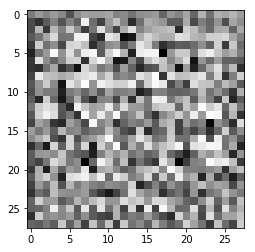

Probability of being real :  [ 0.10912075]


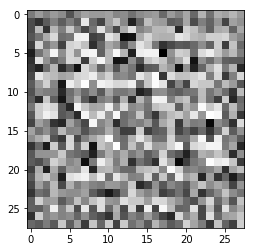

Probability of being real :  [ 0.10463448]


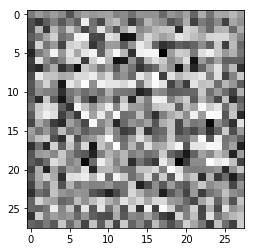

----------------------------------------------------------------------------
Probability of being real :  [ 0.69820976]


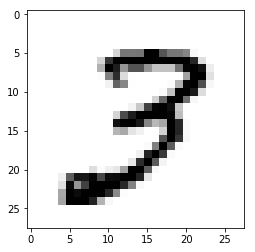

Probability of being real :  [ 0.68710113]


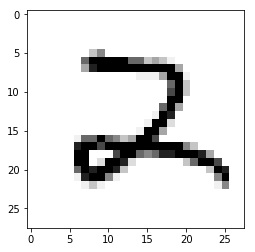

Probability of being real :  [ 0.72411543]


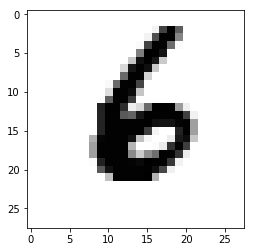

In [8]:
# Testing Time

sample_images = sess.run(generator(3,z_dim))
probs = sess.run(discriminator(x),feed_dict={x:sample_images})
for i in range(3):
    image = sample_images[i,:,:,0]
    print("Probability of being real : ",abs(probs[i]))
    plt.imshow(image,cmap='Greys')
    plt.show()

print ("----------------------------------------------------------------------------")

real_images = mnist.validation.next_batch(3)[0].reshape([3, 28, 28, 1])
probs = sess.run(discriminator(x), {x: real_images})
for i in range(3):
    image = real_images[i,:,:,0]
    print("Probability of being real : ",abs(probs[i]))
    plt.imshow(image,cmap='Greys')
    plt.show()